In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


# 【シングルスイープ】
### ・17パラメータを各一つずつスイープした結果を
### ・LightGBMで学習し、ADSのサロゲートモデルを作成する
# 【パラメータ】
### ・17種類(C101-C108,C201-C206,L101-L102,L201)
### ・0.25pF〜50pF (50ステップ)
### ・0.25nH〜50nH (50ステップ)
### ・T = 0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5 (9ステップ)
# 【計算回数】
### ・50 × 9 = 450ステップ (これを17回繰り返す)

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ベースデータのインポート
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ADS.csv", header=0)

In [ ]:
df.head(1)

,Ref,Val,T12,fpeak,gain,fimg,img,fhimg,himg
0,C102,1.245,0.5,365000000,23.444418,265000000,132.024335,315000000,64.38534


In [ ]:
# データフレームを整理する

# カラムを追加する---------------------------------------------
ncolumn = ["C102","C103","C104","C105","C106","C107","C108",\
           "C201","C202","C203","C204","C205","C206",\
           "L101","L102","L201"]

# デフォルトパラメータを記入する--------------------------------
for i, col in enumerate(ncolumn):
  if(i==0):
    df[col] = 12 # C102
  elif(i==1):
    df[col] = 27 # C103
  elif(i==2):
    df[col] = 8 # C104
  elif(i==3):
    df[col] = 2 # C105
  elif(i==4):
    df[col] = 22 # C106
  elif(i==5):
    df[col] = 6 # C107
  elif(i==6):
    df[col] = 4 # C108
  elif(i==7):
    df[col] = 18 # C201
  elif(i==8):
    df[col] = 1.5 # C202
  elif(i==9):
    df[col] = 1.5 # C203
  elif(i==10):
    df[col] = 18 # C204
  elif(i==11):
    df[col] = 2 # C205
  elif(i==12):
    df[col] = 1.5 # C206
  elif(i==13):
    df[col] = 27 # L101
  elif(i==14):
    df[col] = 27 # L102
  elif(i==15):
    df[col] = 11 # L201

# Refと一致する箇所に値を代入する-----------------------
for col in ncolumn:
  df.loc[df.loc[:,"Ref"] == col,col] = df["Val"]

# 最後に不要なカラムを消す
df = df.drop("Ref", axis=1)
df = df.drop("Val", axis=1)

<ipython-input-4-db16806b1ea7>:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.245  1.245  0.25   0.25   0.25   1.245  2.24   0.25   2.24   1.245
  1.245  2.24   0.25   2.24   1.245  2.24   1.245  2.24   2.24   3.235
  2.24   3.235  3.235  3.235  3.235  3.235  3.235  3.235  3.235  4.23
  4.23   4.23   4.23   4.23   4.23   4.23   4.23   4.23   5.225  5.225
  5.225  5.225  5.225  5.225  5.225  6.22   6.22   6.22   6.22   5.225
  5.225  7.215  6.22   7.215  8.21   7.215  7.215  8.21   8.21   6.22
  7.215 50.    49.005 50.    48.01  49.005 47.015 48.01   6.22  47.015
 46.02  46.02  45.025 45.025 44.03  44.03  43.035 43.035 42.04  41.045
 42.04  40.05  41.045 39.055 40.05  38.06   8.21  37.065 39.055 36.07
 38.06  35.075  9.205 37.065 34.08  33.085 36.07  32.09  35.075 31.095
 34.08  30.1   50.    29.105 33.085 49.005 50.    28.11  32.09  49.005
  9.205 48.01  27.115  9.205 48.01  31.095 47.015 26.12  4

In [ ]:
df.head(1)

,T12,fpeak,gain,fimg,img,fhimg,himg,C102,C103,C104,...,C108,C201,C202,C203,C204,C205,C206,L101,L102,L201
0,0.5,365000000,23.444418,265000000,132.024335,315000000,64.38534,1.245,27.0,8.0,...,4.0,18.0,1.5,1.5,18.0,2.0,1.5,27.0,27.0,11.0


In [ ]:
# 共通カラム
ncolumn = ["C102","C103","C104","C105","C106","C107","C108",\
           "C201","C202","C203","C204","C205","C206",\
           "L101","L102","L201","T12"]

# 訓練データ
train_df1 = pd.concat([df[ncolumn],df["fpeak"]],axis=1)
train_df2 = pd.concat([df[ncolumn],df["gain"]],axis=1)
train_df3 = pd.concat([df[ncolumn],df["img"]],axis=1)
# train_df4 = pd.concat([df[ncolumn],df["himg"]],axis=1)

# ターゲット
test_df1 = train_df1.drop("fpeak",axis=1)
test_df2 = train_df2.drop("gain",axis=1)
test_df3 = train_df3.drop("img",axis=1)
# test_df4 = train_df4.drop("himg",axis=1)

In [ ]:
train_df1["fpeak"] = np.log(train_df1["fpeak"])
train_df2["gain"] = np.log(train_df2["gain"])
train_df3["img"] = np.log(train_df3["img"])
# train_df4["himg"] = np.log(train_df4["himg"])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



In [ ]:
# ライブラリ読み込み
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

# パラメータ設定
lgbm_params = {
    'objective': 'regression',
    # "device": "cuda",
    "device": "cpu",
    'metric': 'mae',
    'boosting_type': 'gbdt',    # BoostingのType
    'num_leaves': 63,           # 葉の数　default = 31,
    'learning_rate': 0.01,       # 学習率　default = 0.1
    'feature_fraction': 0.8,    # 特徴量側のサンプリング　default = 1.0
    'bagging_freq': 5,          # Baggingを何回に1回行うか　default = 0
    'bagging_fraction': 0.8,    # サンプル側のサンプリング　default = 1.0
    # 'num_boost_round': 6000,
    'random_state': 42,
    # 'max_depth': -1,          # 木の深さ（デフォルトは無制限）
    'verbose': -1              # ログ出力の制御
    }

In [ ]:
# 訓練データから除外するカラム
RMV1 = ["fpeak"]
RMV2 = ["gain"]
RMV3 = ["img"]
# RMV4 = ["himg"]

FEATURES1 = [c for c in train_df1.columns if not c in RMV1]
FEATURES2 = [c for c in train_df2.columns if not c in RMV2]
FEATURES3 = [c for c in train_df3.columns if not c in RMV3]
# FEATURES4 = [c for c in train_df4.columns if not c in RMV4]

In [ ]:
%%time

def model_LGB(train, test, FEATURES, Target):

  FOLDS = 5 # 分割数
  kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

  # oof_lgb = np.zeros(len(train))
  # pred_lgb = np.zeros(len(test))
  pred_lgb = []
  models = []
  evaluations_result = {}

  for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, Target]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, Target]
    x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # 予測
  for model in models:
    pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  pred_lgb = np.mean(pred_lgb, axis=0)
  # pred_lgb /= FOLDS

  return models, pred_lgb, evaluations_result

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [ ]:
# 各ターゲットに対するモデル
model1 = []
model2 = []
model3 = []
# model4 = []

# 各モデルの予測値
lgb_output1 = []
lgb_output2 = []
lgb_output3 = []
# lgb_output4 = []

# 各モデルの学習履歴
eval_result1 = {}
eval_result2 = {}
eval_result3 = {}
# eval_result4 = {}

# 学習
model1, lgb_output1, eval_result1 = model_LGB(train_df1, test_df1, FEATURES1, RMV1)
model2, lgb_output2, eval_result2 = model_LGB(train_df2, test_df2, FEATURES2, RMV2)
model3, lgb_output3, eval_result3 = model_LGB(train_df3, test_df3, FEATURES3, RMV3)
# model4, lgb_output4, eval_result4 = model_LGB(train_df4, test_df4, FEATURES4, RMV4)

#########################
### Fold 1
#########################
[100]	train's l1: 0.0429446	valid's l1: 0.0448935
[200]	train's l1: 0.022738	valid's l1: 0.024545
[300]	train's l1: 0.0133813	valid's l1: 0.0151812
[400]	train's l1: 0.00901788	valid's l1: 0.0109772
[500]	train's l1: 0.00702566	valid's l1: 0.00915605
[600]	train's l1: 0.00614232	valid's l1: 0.00825753
[700]	train's l1: 0.00575779	valid's l1: 0.00780367
[800]	train's l1: 0.0055541	valid's l1: 0.00757532
[900]	train's l1: 0.00542023	valid's l1: 0.00744344
[1000]	train's l1: 0.0053052	valid's l1: 0.00736964
[1100]	train's l1: 0.00519681	valid's l1: 0.00726962
[1200]	train's l1: 0.00512062	valid's l1: 0.00720549
[1300]	train's l1: 0.00504081	valid's l1: 0.00715846
[1400]	train's l1: 0.00495738	valid's l1: 0.0070859
[1500]	train's l1: 0.0048782	valid's l1: 0.00702816
[1600]	train's l1: 0.00482703	valid's l1: 0.00699661
[1700]	train's l1: 0.00475669	valid's l1: 0.00695565
[1800]	train's l1: 0.00471206	valid's l1: 0.00693213
[1900

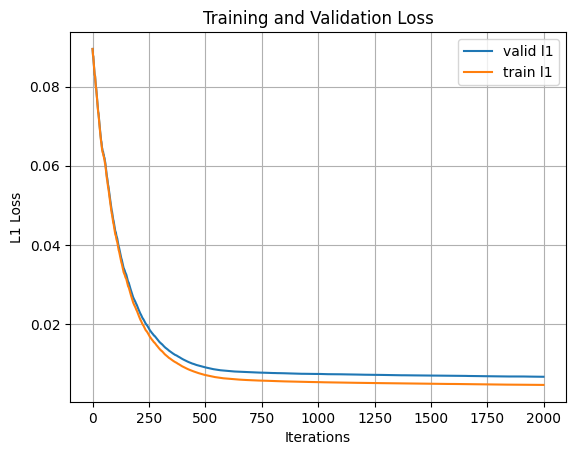

In [ ]:
import matplotlib.pyplot as plt

# 学習曲線 L1
plt.plot(eval_result1['valid']['l1'], label='valid l1')
plt.plot(eval_result1['train']['l1'], label='train l1')
plt.xlabel('Iterations')
plt.ylabel('L1 Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 重要度の算出
print("###########################")
print("## fpeak(センター周波数) ##")
print("###########################")
importance = pd.DataFrame(model1[0].feature_importance(), index=FEATURES1,\
                         columns = ["importance"]).sort_values(by="importance",ascending=False)
print(importance[0:4])

print("###########################")
print("## gain(通過ロス)        ##")
print("###########################")
importance = pd.DataFrame(model2[0].feature_importance(), index=FEATURES2,\
                         columns = ["importance"]).sort_values(by="importance",ascending=False)
print(importance[0:4])

print("###########################")
print("## img(イメージ[dB])     ##")
print("###########################")
importance = pd.DataFrame(model3[0].feature_importance(), index=FEATURES3,\
                         columns = ["importance"]).sort_values(by="importance",ascending=False)
print(importance[0:4])

# print("###########################")
# print("## himg(ハーフ[dB])     ##")
# print("###########################")
# importance = pd.DataFrame(model4[0].feature_importance(), index=FEATURES4,\
#                          columns = ["importance"]).sort_values(by="importance",ascending=False)
# print(importance[0:4])


###########################
## fpeak(センター周波数) ##
###########################
      importance
T12        15778
L102       13516
C107       11581
C108       11388
###########################
## gain(通過ロス)        ##
###########################
      importance
T12        18328
L102       10919
C108       10782
C107       10624
###########################
## img(イメージ[dB])     ##
###########################
      importance
T12        17715
L102       13449
C105       10829
C107       10161


In [ ]:
# どのぐらい正しいか確認
pred_lgb_test = []

# 予測
pred_lgb_test = model1[0].predict(test_df1, num_iteration = model1[0].best_iteration)

In [ ]:
# 確認 (学習データだが、まずは合っていると判断できる)
import random as rd

# 乱数列を生成
t_num = []
for i in range(8):
  t_num.append(rd.randint(0,6000))

np.set_printoptions(precision=2)
print("---------------------------------")
print("----共振周波数[MHz]の予測結果----")
print("---------------------------------")
print("訓練データ",np.exp(train_df1.loc[t_num,"fpeak"].to_numpy()))
print("検証データ",np.exp(pred_lgb_test[t_num]))

---------------------------------
----共振周波数[MHz]の予測結果----
---------------------------------
訓練データ [3.89e+08 3.08e+08 4.48e+08 4.06e+08 4.75e+08 4.90e+08 4.03e+08 4.04e+08]
検証データ [3.89e+08 3.10e+08 4.48e+08 4.06e+08 4.74e+08 4.90e+08 4.04e+08 4.04e+08]


# 【マルチスイープ】
### ・寄与度の高い3パラメータを抽出しマルチスイープする
### ・fpeak, gain, img, himgそれぞれのモデルを作成
# 【パラメータ】
### ・3種類
### ・中心前後 (6ステップ)
### ・T = 下、中、上 (各5ステップ)
# 【計算回数】
### ・6 × 6 × 6 × 5 = 1080ステップ (これを3回繰り返す)

In [ ]:
# マルチスイープデータのインポート

# [1] ゲイン、共振周波数 (fpeak_f○_out.csv)
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fpeak_fL_out.csv", header=0)
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fpeak_fM_out.csv", header=0)
df3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fpeak_fH_out.csv", header=0)

# [2] イメージ (img_f○_out.csv)
df4 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/img_fL_out.csv", header=0)
df5 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/img_fM_out.csv", header=0)
df6 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/img_fH_out.csv", header=0)

# [3] ハーフイメージ (himg_f○_out.csv)
# df7 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/himg_fL_out.csv", header=0)
# df8 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/himg_fM_out.csv", header=0)
# df9 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/himg_fH_out.csv", header=0)

In [ ]:
# 各ファイルのパラメータ
# [1] L102, C107, C108
df_peak = pd.concat([df1,df2,df3],axis=0)
# [2] L102, C105, C107
df_image = pd.concat([df4,df5,df6],axis=0)

In [ ]:
df_image.head(1)

,Val1,Val2,Val3,T12,fpeak,gain,fimg,img,fhimg,himg
0,5.7,1.7,26.7,1.0,385000000,16.70119,285000000,124.515023,335000000,41.831803


In [ ]:
# [1][2]

# カラムを追加する---------------------------------------------
ncolumn = ["C102","C103","C104","C105","C106","C107","C108",\
           "C201","C202","C203","C204","C205","C206",\
           "L101","L102","L201"]

# デフォルトパラメータを記入する--------------------------------
for i, col in enumerate(ncolumn):
  if(i==0):
    df_peak[col] = 12 # C102
    df_image[col] = 12 # C102
  elif(i==1):
    df_peak[col] = 27 # C103
    df_image[col] = 27 # C103
  elif(i==2):
    df_peak[col] = 8 # C104
    df_image[col] = 8 # C104
  elif(i==3):
    df_peak[col] = 2 # C105
    df_image[col] = 2 # C105
  elif(i==4):
    df_peak[col] = 22 # C106
    df_image[col] = 22 # C106
  elif(i==5):
    df_peak[col] = 6 # C107
    df_image[col] = 6 # C107
  elif(i==6):
    df_peak[col] = 4 # C108
    df_image[col] = 4 # C108
  elif(i==7):
    df_peak[col] = 18 # C201
    df_image[col] = 18 # C201
  elif(i==8):
    df_peak[col] = 1.5 # C202
    df_image[col] = 1.5 # C202
  elif(i==9):
    df_peak[col] = 1.5 # C203
    df_image[col] = 1.5 # C203
  elif(i==10):
    df_peak[col] = 18 # C204
    df_image[col] = 18 # C204
  elif(i==11):
    df_peak[col] = 2 # C205
    df_image[col] = 2 # C205
  elif(i==12):
    df_peak[col] = 1.5 # C206
    df_image[col] = 1.5 # C206
  elif(i==13):
    df_peak[col] = 27 # L101
    df_image[col] = 27 # L101
  elif(i==14):
    df_peak[col] = 27 # L102
    df_image[col] = 27 # L102
  elif(i==15):
    df_peak[col] = 11 # L201
    df_image[col] = 11 # L201

# 各Valを代入する
df_peak["L102"] = df_peak["Val1"]
df_peak["C107"] = df_peak["Val2"]
df_peak["C108"] = df_peak["Val3"]

df_image["L102"] = df_image["Val1"]
df_image["C105"] = df_image["Val2"]
df_image["C107"] = df_image["Val3"]

# 最後に不要なカラムを消す
df_peak = df_peak.drop("Val1", axis=1)
df_peak = df_peak.drop("Val2", axis=1)
df_peak = df_peak.drop("Val3", axis=1)

df_image = df_image.drop("Val1", axis=1)
df_image = df_image.drop("Val2", axis=1)
df_image = df_image.drop("Val3", axis=1)

In [ ]:
# データフレームを結合
df_all = pd.concat([df,df_peak,df_image],axis=0, ignore_index=True)

In [ ]:
# ターゲット別にモデルを構築する
# [1] fpeak
# [2] gain
# [3] img
# [4] himg

# 共通カラム
ncolumn = ["C102","C103","C104","C105","C106","C107","C108",\
           "C201","C202","C203","C204","C205","C206",\
           "L101","L102","L201","T12"]

# 訓練データ
train_df1 = pd.concat([df_all[ncolumn],df_all["fpeak"]],axis=1)
train_df2 = pd.concat([df_all[ncolumn],df_all["gain"]],axis=1)
train_df3 = pd.concat([df_all[ncolumn],df_all["img"]],axis=1)
# train_df4 = pd.concat([df_all[ncolumn],df_all["himg"]],axis=1)

# ターゲット
test_df1 = train_df1.drop("fpeak",axis=1)
test_df2 = train_df2.drop("gain",axis=1)
test_df3 = train_df3.drop("img",axis=1)
# test_df4 = train_df4.drop("himg",axis=1)

In [ ]:
# すべてlogでスケールを合わせる
train_df1["fpeak"] = np.log(train_df1["fpeak"])
train_df2["gain"] = np.log(train_df2["gain"])
train_df3["img"] = np.log(train_df3["img"])
# train_df4["himg"] = np.log(train_df4["himg"])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# ライブラリ読み込み
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

# パラメータ設定
lgbm_params = {
    'objective': 'regression',
    # "device": "cuda",
    "device": "cpu",
    'metric': 'mae',
    'boosting_type': 'gbdt',    # BoostingのType
    'num_leaves': 63,           # 葉の数　default = 31,
    'learning_rate': 0.01,       # 学習率　default = 0.1
    'feature_fraction': 0.8,    # 特徴量側のサンプリング　default = 1.0
    'bagging_freq': 5,          # Baggingを何回に1回行うか　default = 0
    'bagging_fraction': 0.8,    # サンプル側のサンプリング　default = 1.0
    # 'num_boost_round': 6000,
    'random_state': 42,
    # 'max_depth': -1,          # 木の深さ（デフォルトは無制限）
    'verbose': -1,              # ログ出力の制御
    'verbose_eval':False
    }

In [ ]:
# 訓練データから除外するカラム
RMV1 = ["fpeak"]
RMV2 = ["gain"]
RMV3 = ["img"]
# RMV4 = ["himg"]

FEATURES1 = [c for c in train_df1.columns if not c in RMV1]
FEATURES2 = [c for c in train_df2.columns if not c in RMV2]
FEATURES3 = [c for c in train_df3.columns if not c in RMV3]
# FEATURES4 = [c for c in train_df4.columns if not c in RMV4]

In [ ]:
%%time

def model_LGB(train, test, FEATURES, Target):

  FOLDS = 5 # 分割数
  kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

  # oof_lgb = np.zeros(len(train))
  # pred_lgb = np.zeros(len(test))
  pred_lgb = []
  models = []
  evaluations_result = {}

  for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, Target]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, Target]
    x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # 予測
  for model in models:
    pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  pred_lgb = np.mean(pred_lgb, axis=0)
  # pred_lgb /= FOLDS

  return models, pred_lgb, evaluations_result

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [ ]:
# 各ターゲットに対するモデル
model1 = [] # 中心周波数
model2 = [] # ゲイン
model3 = [] # イメージ
# model4 = [] # ハーフイメージ

# 各モデルの予測値
lgb_output1 = []
lgb_output2 = []
lgb_output3 = []
# lgb_output4 = []

# 各モデルの学習履歴
eval_result1 = {}
eval_result2 = {}
eval_result3 = {}
# eval_result4 = {}

# 学習
model1, lgb_output1, eval_result1 = model_LGB(train_df1, test_df1, FEATURES1, RMV1)
model2, lgb_output2, eval_result2 = model_LGB(train_df2, test_df2, FEATURES2, RMV2)
model3, lgb_output3, eval_result3 = model_LGB(train_df3, test_df3, FEATURES3, RMV3)
# model4, lgb_output4, eval_result4 = model_LGB(train_df4, test_df4, FEATURES4, RMV4)

#########################
### Fold 1
#########################
[100]	train's l1: 0.0346491	valid's l1: 0.0360769
[200]	train's l1: 0.0177419	valid's l1: 0.0188553
[300]	train's l1: 0.0100618	valid's l1: 0.0109474
[400]	train's l1: 0.00649936	valid's l1: 0.00737097
[500]	train's l1: 0.00479568	valid's l1: 0.00574157
[600]	train's l1: 0.00396805	valid's l1: 0.00491467
[700]	train's l1: 0.00357565	valid's l1: 0.00451524
[800]	train's l1: 0.00336797	valid's l1: 0.00431844
[900]	train's l1: 0.00323848	valid's l1: 0.00419905
[1000]	train's l1: 0.00314026	valid's l1: 0.00411184
[1100]	train's l1: 0.00305552	valid's l1: 0.00403064
[1200]	train's l1: 0.00299556	valid's l1: 0.00396519
[1300]	train's l1: 0.00293475	valid's l1: 0.0039101
[1400]	train's l1: 0.0028751	valid's l1: 0.00386199
[1500]	train's l1: 0.00282019	valid's l1: 0.00380572
[1600]	train's l1: 0.00275743	valid's l1: 0.0037501
[1700]	train's l1: 0.00271255	valid's l1: 0.0037018
[1800]	train's l1: 0.00267547	valid's l1: 0.00366191
[1

# 400M ver.の最適解をリファレンスとして求める
### TL=1.4, ferr=2.8[MHz], gain=7.1[dB], img=94.1[dB]
### TM=2.5, ferr=0.5[MHz], gain=5.6[dB], img=73.7[dB]
### TH=3.6, ferr=4.3[MHz], gain=4.7[dB], img=61.0[dB]

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.1 MB/s eta 0:00:00


In [ ]:
!pip install optunahub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 31.0 MB/s eta 0:00:00


In [ ]:
!pip install cmaes scipy

In [ ]:
# 各モデルの説明
# [1] fpeak, [2] gain, [3] image, [4] himage
# 400Mverの最適解
# T12をスイープする

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル
  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  C105 = 2
  C106 = 22
  C107 = 6
  C108 = 4
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 27
  L201 = 11

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 400e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 435e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 470e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
# optuna.visualization.plot_pareto_front(
#     study,
#     targets=lambda t: (t.values[0], t.values[3], t.values[6]),
#     target_names=["err_fL", "fLgain", "fLimage"],
#     include_dominated_trials=False,
# ).show()

In [ ]:
import optuna
sampler = optuna.samplers.NSGAIISampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-11 11:38:25,043] A new study created in memory with name: no-name-0cc264f9-052d-4947-be90-0c4423df3c37
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
[I 2025-05-11 11:38:25,071] Trial 0 finished with values: [2.8036171277893187, 13.299747373957038, 4.289718096815943, 7.065117197907417, 5.389461142779147, 4.7118847425795245, 94.07504109514157, 67.50245532671345, 61.046323471167256] and parameters: {'TL': 1.3745401188473625, 'TM': 2.950714306409916, 'TH': 3.731993941811405}.
/usr/local/lib/python3.11/dist-pa

In [ ]:
# import optunahub
# study = optuna.create_study(
#     directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],
#         sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler())
# study.optimize(objective, n_trials=100)

[I 2025-05-10 19:03:40,796] A new study created in memory with name: no-name-2ac653e1-f4a1-4dfe-9b42-e1249b4f2ea5
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:03:40,821] Trial 0 finished with values: [11.077219009266555, 0.5108328497959972, 5.808924060534776, 7.2940469524980145, 5.578256995539647, 4.16180339696964, 94.9846593790705, 73.74989685121227, 56.78036163265221] and parameters: {'TL': 1.072645351351522, 'TM': 2.5224881799002947, 'TH': 3.8521327946613724}.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Conver

In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  # print(trial.params)
  print([j for j in trial.values])

[2.8036171277893187, 15.351127943398833, 15.051120566783249, 7.065117197907417, 6.830377926724903, 5.458384387652749, 94.07504109514157, 84.36302486869839, 65.28782959203497]
[4.1850523357784155, 0.9279048716616034, 21.70025262604296, 7.1759000962022705, 5.484171432455161, 5.389461142779147, 96.5691826863798, 72.61892531063306, 67.50245532671345]
[4.1850523357784155, 10.29725335647714, 4.289718096815943, 7.1759000962022705, 6.638228251290854, 4.7118847425795245, 96.5691826863798, 81.30886173325574, 61.046323471167256]
[10.526237027653515, 0.9279048716616034, 21.55207696363002, 7.071440613633681, 5.484171432455161, 5.594731688791344, 95.94178886110228, 72.61892531063306, 67.05886683581771]
[4.1850523357784155, 0.9279048716616034, 4.289718096815943, 7.1759000962022705, 5.484171432455161, 4.7118847425795245, 96.5691826863798, 72.61892531063306, 61.046323471167256]
[2.8036171277893187, 0.9279048716616034, 21.55207696363002, 7.065117197907417, 5.484171432455161, 5.594731688791344, 94.075041

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []

# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])

# 最適化するT12値と誤差[MHz]
print("TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print("TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print("TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

TL=1.4 , err=2.8 , gain=7.1, image=94.1
TM=2.5 , err=0.5 , gain=5.6, image=73.7
TH=3.6 , err=4.3 , gain=4.7, image=61.0


# 次に450M ver.の最適解を求める
### 特徴量の寄与度
### fpeak, gain = L102, C107, C108
### image = L102, C105, C107
### himg = L102, C108, C107
## 【400Mver】
### TL=1.4, ferr=2.8[MHz], gain=7.1[dB], img=94.1[dB]
### TM=2.5, ferr=0.5[MHz], gain=5.6[dB], img=73.7[dB]
### TH=3.6, ferr=4.3[MHz], gain=4.7[dB], img=61.0[dB]

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル
  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

### L102, C107, C108
### L102, C105, C107

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  C105 = 2
  C106 = 22
  C107 = 6
  C108 = 4
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 27
  L201 = 11

  # スイープする定数
  # C102 = trial.suggest_float("C102", 10, 50) # 12.0
  # C103 = trial.suggest_float("C103", 25, 30) # 27.0
  # C104 = trial.suggest_float("C104", 5, 10) # 8.0
  # C105 = trial.suggest_float("C105", 9, 10) # 2.0
  # C106 = trial.suggest_float("C106", 20, 25) # 22.0
  # C107 = trial.suggest_float("C107", 5, 7) # 6.0
  # C108 = trial.suggest_float("C108", 8, 15) # 4.0
  # C201 = trial.suggest_float("C201", 10, 20) # 18.0
  # C202 = trial.suggest_float("C202", 0.5, 5) # 1.5
  # C203 = trial.suggest_float("C203", 0.5, 5) # 1.5
  # C204 = trial.suggest_float("C204", 10, 20) # 18.0
  # C205 = trial.suggest_float("C205", 0.5, 5) # 2.0
  # C206 = trial.suggest_float("C206", 0.5, 5) # 1.5
  # L101 = trial.suggest_float("L101", 25, 30) # 27.0
  L102 = trial.suggest_float("L102", 20, 25) # 27.0
  # L201 = trial.suggest_float("L201", 10, 20) # 11.0

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 450e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 485e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 520e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
import optuna
sampler = optuna.samplers.NSGAIISampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-11 11:38:56,197] A new study created in memory with name: no-name-647f8a7a-fd67-491b-a0c7-ac3adda76e6c
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
[I 2025-05-11 11:38:56,232] Trial 0 finished with values: [14.45063397686243, 8.148647549333095, 0.7232484177703261, 7.690327359831162, 7.425955765194784, 7.343693722340005, 56.19249112485636, 56.1973548575449, 52.80889891789536] and parameters: {'L102': 21.87270059423681, 'TL': 1.9507143064099162, 'TM': 2.731993941811405, 'TH': 3.5986584841970366}.
/usr/loca

In [ ]:
# import optunahub
# study = optuna.create_study(
#     directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],
#         sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler())
# study.optimize(objective, n_trials=100)

[I 2025-05-10 19:06:27,970] A new study created in memory with name: no-name-741df8ce-53f4-4fbe-8185-260dbfcf9e97
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:06:27,993] Trial 0 finished with values: [9.921688546980798, 15.217629220288515, 7.259416101203084, 4.993075063789901, 6.550171413812962, 6.730878285755833, 34.162842036480946, 50.592561468814665, 48.6011791373543] and parameters: {'L102': 20.115502283476744, 'TL': 1.306713170837777, 'TM': 2.791241748066561, 'TH': 3.470530945776442}.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py

In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'L102': 19.162213204002107, 'TL': 1.2123391106782762, 'TM': 2.181824967207101, 'TH': 3.1834045098534336}
[12.072156045472383, 19.220776857007863, 10.348054904723048, 3.2009666039916556, 5.5596662259325855, 6.26675995124241, 28.617254993465387, 45.18498501306964, 45.853625959950406]
{'L102': 18.059264473611897, 'TL': 1.139493860652042, 'TM': 2.292144648535218, 'TH': 3.3663618432936917}
[18.504979162313045, 2.0472459003621934, 7.607172487319291, 1.6650069783740558, 4.1433582611951065, 6.002932369363477, 23.22626196155708, 41.990343007772104, 48.97844218789271]
{'L102': 19.697494707820944, 'TL': 1.894827350427649, 'TM': 2.597899978811085, 'TH': 3.921874235023117}
[52.795308097442806, 15.217629220288515, 35.09256322293198, 5.408714594703949, 6.550171413812962, 6.941490539872906, 47.476490497191136, 50.592561468814665, 49.440625771708476]
{'L102': 18.85635173342973, 'TL': 1.0740446517340905, 'TM': 2.3584657285442727, 'TH': 3.1158690595251297}
[9.597398384827972, 2.2835585237127543, 10.3480

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []
optC105 = []
optC107 = []
optC108 = []
optL102 = []


# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])
  # optC105.append(t.params["C105"])
  # optC107.append(t.params["C107"])
  # optC108.append(t.params["C108"])
  optL102.append(t.params["L102"])

# 最適化するT12値と誤差[MHz]
print(
    # "C105="+f'{optC105[fLerr.index(min(fLerr))]:.1f}',
    #   ", C107="+f'{optC107[fLerr.index(min(fLerr))]:.1f}',
    #   ", C108="+f'{optC108[fLerr.index(min(fLerr))]:.1f}',
      ", L102="+f'{optL102[fLerr.index(min(fLerr))]:.1f}',
      ", TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print(
    # "C105="+f'{optC105[fMerr.index(min(fMerr))]:.1f}',
    #   ", C107="+f'{optC107[fMerr.index(min(fMerr))]:.1f}',
    #   ", C108="+f'{optC108[fMerr.index(min(fMerr))]:.1f}',
      ", L102="+f'{optL102[fMerr.index(min(fMerr))]:.1f}',
      ", TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print(
    # "C105="+f'{optC105[fHerr.index(min(fHerr))]:.1f}',
    #   ", C107="+f'{optC107[fHerr.index(min(fHerr))]:.1f}',
    #   ", C108="+f'{optC108[fHerr.index(min(fHerr))]:.1f}',
      ", L102="+f'{optL102[fHerr.index(min(fHerr))]:.1f}',
      ", TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

, L102=21.6 , TL=1.3 , err=0.9 , gain=6.1, image=42.1
, L102=21.5 , TM=2.7 , err=1.8 , gain=6.6, image=54.7
, L102=21.9 , TH=3.6 , err=0.7 , gain=7.3, image=52.8


### L102の解は 21-23の範囲
## 【450Mver】
### ・TL=1.3, ferr=0.9, gain=6.1, img=42.1
### ・TM=2.6, ferr=1.8, gain=6.6, img=54.7
### ・TH=3.7, ferr=0.7, gain=7.3, img=52.8
## 【400Mver】
### ・TL=1.4, ferr=2.8, gain=7.1, img=94.1
### ・TM=2.5, ferr=0.5, gain=5.6, img=73.7
### ・TH=3.6, ferr=4.3, gain=4.7, img=61.0

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル
  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

### L102, C107, C108
### L102, C105, C107

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  C105 = 2
  C106 = 22
  C107 = 6
  C108 = 4
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 27
  L201 = 11

  # スイープする定数
  # C102 = trial.suggest_float("C102", 10, 50) # 12.0
  # C103 = trial.suggest_float("C103", 25, 30) # 27.0
  # C104 = trial.suggest_float("C104", 5, 10) # 8.0
  # C105 = trial.suggest_float("C105", 9, 10) # 2.0
  # C106 = trial.suggest_float("C106", 20, 25) # 22.0
  C107 = trial.suggest_float("C107", 5.0, 6.0) # 6.0
  # C108 = trial.suggest_float("C108", 8, 15) # 4.0
  # C201 = trial.suggest_float("C201", 10, 20) # 18.0
  # C202 = trial.suggest_float("C202", 0.5, 5) # 1.5
  # C203 = trial.suggest_float("C203", 0.5, 5) # 1.5
  # C204 = trial.suggest_float("C204", 10, 20) # 18.0
  # C205 = trial.suggest_float("C205", 0.5, 5) # 2.0
  # C206 = trial.suggest_float("C206", 0.5, 5) # 1.5
  # L101 = trial.suggest_float("L101", 25, 30) # 27.0
  L102 = trial.suggest_float("L102", 22, 23) # 27.0
  # L201 = trial.suggest_float("L201", 10, 20) # 11.0

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 450e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 485e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 520e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
import optuna
sampler = optuna.samplers.NSGAIISampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-11 11:39:24,616] A new study created in memory with name: no-name-fd3c1d42-faea-4bb8-9b15-882c42532e78
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
[I 2025-05-11 11:39:24,636] Trial 0 finished with values: [6.9913673768914935, 12.474603229535044, 39.59288726088113, 11.907407492613931, 11.496587679758708, 11.413868373280112, 59.21845049986563, 75.99365098688637, 74.23185900535152] and parameters: {'C107': 5.374540118847363, 'L102': 22.950714306409917, 'TL': 1.731993941811405, 'TM': 2.5986584841970366, 'TH

In [ ]:
# import optunahub
# study = optuna.create_study(
#     directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],
#         sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler())
# study.optimize(objective, n_trials=100)

[I 2025-05-10 19:09:42,377] A new study created in memory with name: no-name-5f96c1f2-894c-4191-8399-9e427ccd02d5
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:09:42,405] Trial 0 finished with values: [21.516834354664503, 33.60626782371598, 1.199256738867104, 10.105716395456936, 9.421060837575643, 7.942758476946477, 50.77808868723947, 63.83921967203607, 56.560631056100355] and parameters: {'C107': 5.902797619777656, 'L102': 22.127876244955132, 'TL': 1.1701974567861315, 'TM': 2.3649620830673967, 'TH': 3.699404589957386}.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/d

In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []
optC105 = []
optC107 = []
optC108 = []
optL102 = []


# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])
  # optC105.append(t.params["C105"])
  optC107.append(t.params["C107"])
  # optC108.append(t.params["C108"])
  optL102.append(t.params["L102"])

# 最適化するT12値と誤差[MHz]
print(
    # "C105="+f'{optC105[fLerr.index(min(fLerr))]:.1f}',
      ", C107="+f'{optC107[fLerr.index(min(fLerr))]:.1f}',
    #   ", C108="+f'{optC108[fLerr.index(min(fLerr))]:.1f}',
      ", L102="+f'{optL102[fLerr.index(min(fLerr))]:.1f}',
      ", TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print(
    # "C105="+f'{optC105[fMerr.index(min(fMerr))]:.1f}',
      ", C107="+f'{optC107[fMerr.index(min(fMerr))]:.1f}',
    #   ", C108="+f'{optC108[fMerr.index(min(fMerr))]:.1f}',
      ", L102="+f'{optL102[fMerr.index(min(fMerr))]:.1f}',
      ", TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print(
    # "C105="+f'{optC105[fHerr.index(min(fHerr))]:.1f}',
      ", C107="+f'{optC107[fHerr.index(min(fHerr))]:.1f}',
    #   ", C108="+f'{optC108[fHerr.index(min(fHerr))]:.1f}',
      ", L102="+f'{optL102[fHerr.index(min(fHerr))]:.1f}',
      ", TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

, C107=5.2 , L102=22.3 , TL=1.5 , err=1.6 , gain=11.1, image=49.2
, C107=5.6 , L102=22.9 , TM=2.9 , err=1.9 , gain=7.3, image=64.2
, C107=5.2 , L102=22.1 , TH=3.7 , err=1.0 , gain=11.6, image=65.8


### L102 = 22.1-22.9 nH
### C107 = 5.2-5.6 pF
## 【450Mver】
### ・TL=1.3, err=0.9, gain=6.1, img=42.1
### ・TM=2.6, err=1.8, gain=6.6, img=54.7
### ・TH=3.7, err=0.7, gain=7.3, img=52.8
### ↓
### ・TL=1.5, err=1.6, gain=11.1, img=49.2
### ・TM=2.9, err=1.9, gain=7.3,  img=64.2
### ・TH=3.8, err=1.0, gain=11.6, img=65.8
## 【400Mver】
### ・TL=1.4, err=2.8, gain=7.1, img=94.1
### ・TM=2.5, err=0.5, gain=5.6, img=73.7
### ・TH=3.6, err=4.3, gain=4.7, img=61.0

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル
  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

### L102, C107, C108
### L102, C105, C107

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  C105 = 2
  C106 = 22
  C107 = 6
  C108 = 4
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 27
  L201 = 11

  # スイープする定数
  # C102 = trial.suggest_float("C102", 10, 50) # 12.0
  # C103 = trial.suggest_float("C103", 25, 30) # 27.0
  # C104 = trial.suggest_float("C104", 5, 10) # 8.0
  C105 = trial.suggest_float("C105", 1.5, 2.0) # 2.0
  # C106 = trial.suggest_float("C106", 20, 25) # 22.0
  C107 = trial.suggest_float("C107", 5.0, 6) # 6.0
  # C108 = trial.suggest_float("C108", 8, 15) # 4.0
  # C201 = trial.suggest_float("C201", 10, 20) # 18.0
  # C202 = trial.suggest_float("C202", 0.5, 5) # 1.5
  # C203 = trial.suggest_float("C203", 0.5, 5) # 1.5
  # C204 = trial.suggest_float("C204", 10, 20) # 18.0
  # C205 = trial.suggest_float("C205", 0.5, 5) # 2.0
  # C206 = trial.suggest_float("C206", 0.5, 5) # 1.5
  # L101 = trial.suggest_float("L101", 25, 30) # 27.0
  L102 = trial.suggest_float("L102", 22, 23) # 27.0
  # L201 = trial.suggest_float("L201", 10, 20) # 11.0

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 450e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 485e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 520e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
import optuna
sampler = optuna.samplers.NSGAIISampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-11 11:40:01,271] A new study created in memory with name: no-name-fad0a4cf-2eb0-46e7-add4-b4683257e7d1
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
[I 2025-05-11 11:40:01,296] Trial 0 finished with values: [12.317576826312006, 30.95329657283503, 41.40407822508067, 10.656880101883967, 10.729361328368052, 8.060167553740124, 68.97921920010404, 78.36467706816933, 69.27971139202943] and parameters: {'C105': 1.6872700594236814, 'C107': 5.950714306409916, 'L102': 22.731993941811407, 'TL': 1.5986584841970366, 'T

In [ ]:
# import optunahub
# study = optuna.create_study(
#     directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],
#         sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler())
# study.optimize(objective, n_trials=100)

[I 2025-05-10 19:11:32,586] A new study created in memory with name: no-name-c1b1b0d9-3864-4ed0-b597-af46ee1c3463
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:11:32,609] Trial 0 finished with values: [15.908228082653642, 37.44581811642009, 27.489991520076394, 9.734136230395507, 9.890655733536663, 8.115105081361708, 66.1972172414046, 70.12956174775371, 67.40248716210945] and parameters: {'C105': 1.672581479989846, 'C107': 5.5449831647851076, 'L102': 22.295627943761357, 'TL': 1.7944562174391403, 'TM': 2.38852337712522, 'TH': 3.1666909986726655}.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/u

In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []
optC105 = []
optC107 = []
optC108 = []
optL102 = []


# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])
  optC105.append(t.params["C105"])
  optC107.append(t.params["C107"])
  # optC108.append(t.params["C108"])
  optL102.append(t.params["L102"])

# 最適化するT12値と誤差[MHz]
print(
    "C105="+f'{optC105[fLerr.index(min(fLerr))]:.1f}',
      ", C107="+f'{optC107[fLerr.index(min(fLerr))]:.1f}',
      # ", C108="+f'{optC108[fLerr.index(min(fLerr))]:.1f}',
      ", L102="+f'{optL102[fLerr.index(min(fLerr))]:.1f}',
      ", TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print(
    "C105="+f'{optC105[fMerr.index(min(fMerr))]:.1f}',
      ", C107="+f'{optC107[fMerr.index(min(fMerr))]:.1f}',
      # ", C108="+f'{optC108[fMerr.index(min(fMerr))]:.1f}',
      ", L102="+f'{optL102[fMerr.index(min(fMerr))]:.1f}',
      ", TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print(
    "C105="+f'{optC105[fHerr.index(min(fHerr))]:.1f}',
      ", C107="+f'{optC107[fHerr.index(min(fHerr))]:.1f}',
      # ", C108="+f'{optC108[fHerr.index(min(fHerr))]:.1f}',
      ", L102="+f'{optL102[fHerr.index(min(fHerr))]:.1f}',
      ", TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

C105=1.8 , C107=5.2 , L102=22.7 , TL=1.4 , err=0.8 , gain=13.6, image=59.7
C105=1.6 , C107=6.0 , L102=22.7 , TM=2.9 , err=0.0 , gain=7.5, image=67.7
C105=1.7 , C107=5.5 , L102=22.9 , TH=3.9 , err=0.2 , gain=6.0, image=63.8


### L102 = 22.8-23.0 nH
### C107 = 5.2-6.0 pF
### C105 = 1.5-2.0 pF
## 【450Mver】
### ・TL=1.5, err=1.6, gain=11.1, img=49.2
### ・TM=2.9, err=1.9, gain=7.3,  img=64.2
### ・TH=3.8, err=1.0, gain=11.6, img=65.8
### ↓
### ・TL=1.8, err=0.8, gain=13.6, img=59.7
### ・TM=1.6, err=0.0, gain=7.5,  img=67.7
### ・TH=1.7, err=0.2, gain=5.8, img=63.8
## 【400Mver】
### ・TL=1.4, err=2.8, gain=7.1, img=94.1
### ・TM=2.5, err=0.5, gain=5.6, img=73.7
### ・TH=3.6, err=4.3, gain=4.7, img=61.0

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル
  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

### L102, C107, C108
### L102, C105, C107

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  C105 = 2
  C106 = 22
  C107 = 6
  C108 = 4
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 27
  L201 = 11

  # スイープする定数
  C105 = trial.suggest_float("C105", 1.5, 1.5) # 2.0
  C107 = trial.suggest_float("C107", 6.0, 6) # 6.0
  C108 = trial.suggest_float("C108", 6.0, 6.0) # 4.0
  L102 = trial.suggest_float("L102", 22.0, 22.0) # 27.0

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 450e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 485e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 520e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
import optuna
sampler = optuna.samplers.NSGAIISampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-11 11:52:13,433] A new study created in memory with name: no-name-e906e031-2842-4ccb-81eb-7b8c6f9c011b
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
[I 2025-05-11 11:52:13,523] Trial 0 finished with values: [10.189022129944325, 1.6867395095632076, 11.492450273752093, 15.302287031354176, 17.382165989689973, 11.847801293663432, 54.71224512313616, 63.01146255858203, 58.74155064943908] and parameters: {'C105': 1.5, 'C107': 6.0, 'C108': 6.0, 'L102': 22.0, 'TL': 1.3745401188473625, 'TM': 2.950714306409916, 'TH'

In [ ]:
# import optunahub
# study = optuna.create_study(
#     directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],
#         sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler())
# study.optimize(objective, n_trials=100)

[I 2025-05-10 23:37:29,102] A new study created in memory with name: no-name-f9e21a38-f917-4d56-9778-978253f0de31
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 23:37:29,123] Trial 0 finished with values: [13.66689333794278, 12.568716437096834, 35.98681707531458, 23.415130215972475, 24.41301504822411, 23.95161769643978, 59.00331430857204, 66.50595401430479, 68.34006000403353] and parameters: {'TL': 1.2888622333418618, 'TM': 2.6381379691823836, 'TH': 3.1907123293855397}.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Conv

In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []
optC105 = []
optC107 = []
optC108 = []
optL102 = []


# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])
  optC105.append(t.params["C105"])
  optC107.append(t.params["C107"])
  optC108.append(t.params["C108"])
  optL102.append(t.params["L102"])

# 最適化するT12値と誤差[MHz]
print(
    "C105="+f'{optC105[fLerr.index(min(fLerr))]:.1f}',
      ", C107="+f'{optC107[fLerr.index(min(fLerr))]:.1f}',
      ", C108="+f'{optC108[fLerr.index(min(fLerr))]:.1f}',
      ", L102="+f'{optL102[fLerr.index(min(fLerr))]:.1f}',
      ", TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print(
    "C105="+f'{optC105[fMerr.index(min(fMerr))]:.1f}',
      ", C107="+f'{optC107[fMerr.index(min(fMerr))]:.1f}',
      ", C108="+f'{optC108[fMerr.index(min(fMerr))]:.1f}',
      ", L102="+f'{optL102[fMerr.index(min(fMerr))]:.1f}',
      ", TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print(
    "C105="+f'{optC105[fHerr.index(min(fHerr))]:.1f}',
      ", C107="+f'{optC107[fHerr.index(min(fHerr))]:.1f}',
      ", C108="+f'{optC108[fHerr.index(min(fHerr))]:.1f}',
      ", L102="+f'{optL102[fHerr.index(min(fHerr))]:.1f}',
      ", TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

C105=1.5 , C107=6.0 , C108=6.0 , L102=22.0 , TL=1.8 , err=3.0 , gain=19.7, image=62.1
C105=1.5 , C107=6.0 , C108=6.0 , L102=22.0 , TM=3.0 , err=1.7 , gain=17.4, image=63.0
C105=1.5 , C107=6.0 , C108=6.0 , L102=22.0 , TH=3.8 , err=2.2 , gain=10.6, image=53.8


### 【最終結果】
### L102 = 22.8-22.9 nH
### C107 = 5.2-5.4 pF
### C105 = 1.5-1.8 pF
### C107 = 5.2-5.4 pF
## 【450Mver】
### ・TL=1.8, err=0.8, gain=13.6, img=59.7
### ・TM=1.6, err=0.0, gain=7.5,  img=67.7
### ・TH=1.7, err=0.2, gain=5.8, img=63.8
### ↓
### ・TL=1.9, err=0.4, gain=21.4,  img=71.6
### ・TM=3.0, err=6.4, gain=19.3,  img=75.3
### ・TH=4.6, err=4.6, gain=13.2, img=69.6
## 【400Mver】
### ・TL=1.4, err=2.8, gain=7.1, img=94.1
### ・TM=2.5, err=0.5, gain=5.6, img=73.7
### ・TH=3.6, err=4.3, gain=4.7, img=61.0
### C105=1.7, C107=5.2, C108=5.3, L102=22.9

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル
  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

### L102, C107, C108
### L102, C105, C107

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  # C105 = 2
  C105 = 1.5
  C105 = 1.8
  C106 = 22
  # C107 = 6
  C107 = 5
  # C108 = 4
  C108 = 5
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 22
  # L102 = 27
  L201 = 11

  # スイープする定数
  # C105 = trial.suggest_float("C105", 1.5, 2.0) # 2.0
  # C107 = trial.suggest_float("C107", 5.2, 6) # 6.0
  # C108 = trial.suggest_float("C108", 5.3, 5.5) # 4.0
  # L102 = trial.suggest_float("L102", 22.8, 23) # 27.0

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 450e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 485e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 520e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
import optuna
sampler = optuna.samplers.NSGAIISampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-11 11:45:55,215] A new study created in memory with name: no-name-fde80deb-3136-42ff-911d-e7216b5baff0
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
[I 2025-05-11 11:45:55,236] Trial 0 finished with values: [2.394017675965011, 4.850103303915263, 11.165811288857997, 18.07924969694932, 19.432627872486524, 19.452250440531472, 50.07253347608284, 70.40757446888466, 67.1054117698012] and parameters: {'TL': 1.3745401188473625, 'TM': 2.950714306409916, 'TH': 3.731993941811405}.
/usr/local/lib/python3.11/dist-pack

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []
# optC105 = []
# optC107 = []
# optC108 = []
# optL102 = []


# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])
  # optC105.append(t.params["C105"])
  # optC107.append(t.params["C107"])
  # optC108.append(t.params["C108"])
  # optL102.append(t.params["L102"])

# 最適化するT12値と誤差[MHz]
print(
    # "C105="+f'{optC105[fLerr.index(min(fLerr))]:.1f}',
    #   ", C107="+f'{optC107[fLerr.index(min(fLerr))]:.1f}',
    #   ", C108="+f'{optC108[fLerr.index(min(fLerr))]:.1f}',
    #   ", L102="+f'{optL102[fLerr.index(min(fLerr))]:.1f}',
      ", TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print(
    # "C105="+f'{optC105[fMerr.index(min(fMerr))]:.1f}',
    #   ", C107="+f'{optC107[fMerr.index(min(fMerr))]:.1f}',
    #   ", C108="+f'{optC108[fMerr.index(min(fMerr))]:.1f}',
    #   ", L102="+f'{optL102[fMerr.index(min(fMerr))]:.1f}',
      ", TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print(
    # "C105="+f'{optC105[fHerr.index(min(fHerr))]:.1f}',
    #   ", C107="+f'{optC107[fHerr.index(min(fHerr))]:.1f}',
    #   ", C108="+f'{optC108[fHerr.index(min(fHerr))]:.1f}',
    #   ", L102="+f'{optL102[fHerr.index(min(fHerr))]:.1f}',
      ", TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

, TL=1.4 , err=2.4 , gain=18.1, image=50.1
, TM=3.0 , err=4.9 , gain=19.4, image=70.4
, TH=4.0 , err=7.6 , gain=15.9, image=64.0


### ここまではあくまで探索範囲を狭めて最適化しただけで全自動ではない。
### 次に全自動サンプルを試みる

In [ ]:
# fpeak最適化の一般解
def predict(T12,C102,C103,C104,C105,C106,C107,C108,
               C201,C202,C203,C204,C205,C206,L101,L102,L201):

  # データフレームの編集
  df = train_df1.drop("fpeak",axis=1).loc[0]

  # 入力変数
  df["T12"] = T12
  df["C102"] = C102
  df["C103"] = C103
  df["C104"] = C104
  df["C105"] = C105
  df["C106"] = C106
  df["C107"] = C107
  df["C108"] = C108
  df["C201"] = C201
  df["C202"] = C202
  df["C203"] = C203
  df["C204"] = C204
  df["C205"] = C205
  df["C206"] = C206
  df["L101"] = L101
  df["L102"] = L102
  df["L201"] = L201

  tmp1 = model1[0].predict(df,num_iteration = model1[0].best_iteration) # fpeakのモデル
  tmp2 = model2[0].predict(df,num_iteration = model2[0].best_iteration) # gainのモデル
  tmp3 = model3[0].predict(df,num_iteration = model3[0].best_iteration) # imageのモデル

  return float(tmp1[0]), float(tmp2[0]), float(tmp3[0])

# 目的関数
def objective(trial):

### L102, C107, C108
### L102, C105, C107

  # 400Mverの定数
  C102 = 12
  C103 = 27
  C104 = 8
  C105 = 2
  C106 = 22
  C107 = 6
  C108 = 4
  C201 = 18
  C202 = 1.5
  C203 = 1.5
  C204 = 18
  C205 = 2
  C206 = 1.5
  L101 = 27
  L102 = 27
  L201 = 11

  # スイープする定数
  # C102 = trial.suggest_float("C102", 10, 50) # 12.0
  # C103 = trial.suggest_float("C103", 25, 30) # 27.0
  # C104 = trial.suggest_float("C104", 5, 10) # 8.0
  C105 = trial.suggest_float("C105", 0.5, 50) # 2.0
  # C106 = trial.suggest_float("C106", 20, 25) # 22.0
  C107 = trial.suggest_float("C107", 0.5, 50) # 6.0
  C108 = trial.suggest_float("C108", 0.5, 50) # 4.0
  # C201 = trial.suggest_float("C201", 10, 20) # 18.0
  # C202 = trial.suggest_float("C202", 0.5, 5) # 1.5
  # C203 = trial.suggest_float("C203", 0.5, 5) # 1.5
  # C204 = trial.suggest_float("C204", 10, 20) # 18.0
  # C205 = trial.suggest_float("C205", 0.5, 5) # 2.0
  # C206 = trial.suggest_float("C206", 0.5, 5) # 1.5
  # L101 = trial.suggest_float("L101", 25, 30) # 27.0
  L102 = trial.suggest_float("L102", 0.5, 50) # 27.0
  # L201 = trial.suggest_float("L201", 10, 20) # 11.0

  # fL-------------------------------------
  TL = trial.suggest_float("TL", 1.0, 2.0)
  fLpeak, fLgain, fLimage = np.exp(predict(TL,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fL_target = 450e6

  # fM-------------------------------------
  TM = trial.suggest_float("TM", 2.0, 3.0)
  fMpeak, fMgain, fMimage = np.exp(predict(TM,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fM_target = 485e6

  # fH-------------------------------------
  TH = trial.suggest_float("TH", 3.0, 4.0)
  fHpeak, fHgain, fHimage = np.exp(predict(TH,C102,C103,C104,C105,C106,C107,C108,
                  C201,C202,C203,C204,C205,C206,L101,L102,L201))
  fH_target = 520e6

  # 誤差
  err_fL = abs(fLpeak - fL_target)/1e6
  err_fM = abs(fMpeak - fM_target)/1e6
  err_fH = abs(fHpeak - fH_target)/1e6

  return err_fL, err_fM, err_fH, fLgain, fMgain, fHgain, fLimage, fMimage, fHimage

In [ ]:
import optuna
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(
    directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-05-10 19:38:53,978] A new study created in memory with name: no-name-65dff1ef-f0a4-4410-8027-2cfe75a208b6
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:38:53,998] Trial 0 finished with values: [146.35543532835828, 135.0695455940172, 103.48471100493747, 0.83841253170152, 0.8917725359036489, 0.9217858854966353, 34.70110081092349, 45.49788319075883, 30.964510811772435] and parameters: {'C105': 19.039735882944445, 'C107': 47.56035816729085, 'C108': 36.733700119664555, 'L102': 30.13359496775331, 'TL': 1.1560186404424364, 'TM': 2.1559945203362028, 'TH': 3.0580836121681996}.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting 

In [ ]:
optuna.visualization.plot_param_importances(study).show()

In [ ]:
optuna.visualization.plot_slice(
    study,
    params=["C107","L102"],
    target=lambda t: t.values[3]
)

#     target_names=["err_fL", "fLgain", "fLimage"],
#     include_dominated_trials=False,


In [ ]:
# import optunahub
# study = optuna.create_study(
#     directions = ["minimize","minimize","minimize","maximize","maximize","maximize","maximize","maximize","maximize"],
#         sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler())
# study.optimize(objective, n_trials=100)

[I 2025-05-10 19:36:24,645] A new study created in memory with name: no-name-c66348d0-5fed-4dd8-9b6a-a2688b22d856
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:36:24,657] Trial 0 pruned. Too large value: [19.80303274]
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:36:24,665] Trial 1 pruned. Too large value: [19.57716758]
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:36:24,673] Trial 2 pruned. Too large value: [19.76925645]
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse matrix.

[I 2025-05-10 19:36:24,680] Trial 3 pruned. Too large value: [19.73203164]
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning:

Converting data to scipy sparse 

In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
# 誤差とパラメータ宣言
xpos = []
fLerr = []
fMerr = []
fHerr = []
fLgain = []
fMgain = []
fHgain = []
fLimage = []
fMimage = []
fHimage = []
fLpar = []
fMpar = []
fHpar = []
optC105 = []
optC107 = []
optC108 = []
optL102 = []


# 誤差一覧
for i, t in enumerate(study.best_trials):
  xpos.append(i)
  fLerr.append(t.values[0])
  fMerr.append(t.values[1])
  fHerr.append(t.values[2])
  fLgain.append(t.values[3])
  fMgain.append(t.values[4])
  fHgain.append(t.values[5])
  fLimage.append(t.values[6])
  fMimage.append(t.values[7])
  fHimage.append(t.values[8])
  fLpar.append(t.params["TL"])
  fMpar.append(t.params["TM"])
  fHpar.append(t.params["TH"])
  optC105.append(t.params["C105"])
  optC107.append(t.params["C107"])
  optC108.append(t.params["C108"])
  optL102.append(t.params["L102"])

# 最適化するT12値と誤差[MHz]
print(
    "C105="+f'{optC105[fLerr.index(min(fLerr))]:.1f}',
      ", C107="+f'{optC107[fLerr.index(min(fLerr))]:.1f}',
      ", C108="+f'{optC108[fLerr.index(min(fLerr))]:.1f}',
      ", L102="+f'{optL102[fLerr.index(min(fLerr))]:.1f}',
      ", TL="f'{fLpar[fLerr.index(min(fLerr))]:.1f}',
      ", err="+f'{min(fLerr):.1f}',
      ", gain="+f'{fLgain[fLerr.index(min(fLerr))]:.1f}'
      ", image="+f'{fLimage[fLerr.index(min(fLerr))]:.1f}'
      )

print(
    "C105="+f'{optC105[fMerr.index(min(fMerr))]:.1f}',
      ", C107="+f'{optC107[fMerr.index(min(fMerr))]:.1f}',
      ", C108="+f'{optC108[fMerr.index(min(fMerr))]:.1f}',
      ", L102="+f'{optL102[fMerr.index(min(fMerr))]:.1f}',
      ", TM="f'{fMpar[fMerr.index(min(fMerr))]:.1f}',
      ", err="+f'{min(fMerr):.1f}',
      ", gain="+f'{fMgain[fMerr.index(min(fMerr))]:.1f}'
      ", image="+f'{fMimage[fMerr.index(min(fMerr))]:.1f}'
      )

print(
    "C105="+f'{optC105[fHerr.index(min(fHerr))]:.1f}',
      ", C107="+f'{optC107[fHerr.index(min(fHerr))]:.1f}',
      ", C108="+f'{optC108[fHerr.index(min(fHerr))]:.1f}',
      ", L102="+f'{optL102[fHerr.index(min(fHerr))]:.1f}',
      ", TH="f'{fHpar[fHerr.index(min(fHerr))]:.1f}',
      ", err="+f'{min(fHerr):.1f}',
      ", gain="+f'{fHgain[fHerr.index(min(fHerr))]:.1f}'
      ", image="+f'{fHimage[fHerr.index(min(fHerr))]:.1f}'
      )

ValueError: min() arg is an empty sequence

In [ ]:
pred_lgb1 = pd.DataFrame(pred_lgb1)
pred_lgb2 = pd.DataFrame(pred_lgb2)
pred_lgb3 = pd.DataFrame(pred_lgb3)
pred_lgb4 = pd.DataFrame(pred_lgb4)

In [ ]:
pred_lgb1.to_csv("fpeak.csv", header=False, index=False)
pred_lgb2.to_csv("gain.csv", header=False, index=False)
pred_lgb3.to_csv("image.csv", header=False, index=False)
pred_lgb4.to_csv("himage.csv", header=False, index=False)
# pred_lgb.to_csv("fpeak.csv", header=False, index=False)